In [135]:
!pip install emoji
!pip install wordsegment
!pip install tensorflow
!pip install scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [136]:
import random as python_random
import argparse
import numpy as np
import tensorflow as tf
import emoji
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

from gensim.models import KeyedVectors

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Bidirectional, GRU, LSTM,Embedding, Dense, Conv1D, MaxPooling1D, concatenate, Flatten, Dropout

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

from wordsegment import load, segment



In [137]:
# Setting random seeds
np.random.seed(1234)
tf.random.set_seed(1234)
python_random.seed(1234)

In [138]:
def create_arg_parser():
    """Function that builds up all the arguments used in this script.
    :return: the parsed arguments
    """
    drive_path = "" # File path in drive, can be removed when using as a solo python script.
    parser = argparse.ArgumentParser()

    parser.add_argument('-f') # needed to run in google collab, can be removed outside collab.
    parser.add_argument("-i",
                        "--train_file",
                        default=drive_path + 'train.tsv',
                        type=str,
                        help="Input file to learn from (default train.tsv)"
    )
    parser.add_argument("-d",
                        "--dev_file",
                        type=str,
                        default=drive_path + 'dev.tsv',
                        help="Separate dev set to read in (default dev.tsv)"
    )
    parser.add_argument("-t",
                        "--test_file",
                        type=str,
                        default=drive_path + 'test.tsv',
                        help="If added, use trained model to predict on test set"
    )
    parser.add_argument(
        "-vec",
        "--vectorizer",
        default="word2vec",
        type=str,
        help="Vectorizer to use (word2vec, fasttext) (default word2vec)",
    )
    # Emoji to textual representation
    parser.add_argument(
        "-dem",
        "--demojize",
        action="store_true",
        help="Demojize the input to rewrite emoji's to their textual representation e.g.,  ❤ -> :heart: ",

    )
    # Emoji to natural language
    parser.add_argument(
        "-demclean",
        "--demojize_clean",
        action="store_true",
        help="Demojize the input to rewrite emoji's to natural language in order to preserve semantic meaning eg., "
             "❤ -> heart",

    )
    parser.add_argument(
        "-seg",
        "--wordsegment",
        action="store_true",
        help="Perform wordsegmentation on hashtags to better detect profanity and other offensive language",

    )
    
    args = parser.parse_args()    

    filename = "lstm_" + args.vectorizer
    
    if args.demojize:
        filename += "_demojize"

    if args.demojize_clean:
        filename += "_demojizeclean"

    if args.wordsegment:
        filename += "_wordsegment"
    
    args.model_name = filename

    return args

In [139]:
def segment_hashtag(hashtag):
    """
    Segments a hashtag into words.
    :param str hashtag: The hashtag to segment.
    :return: The segmented hashtag.
    """
    try:
        segments = segment(hashtag)
        return segments if segments else [hashtag]
    except ValueError:
        return [hashtag]

In [140]:
def read_corpus(corpus_file):
    """
    Reads the corpus file and gets the documents with labels.
    :param str corpus_file: Path to the corpus file.
    :return: the document
    :return: the labels
    """
    documents = []
    labels = []

    with open(corpus_file, encoding="utf-8") as in_file:
        for line in in_file:
            if args.demojize:
                line = emoji.demojize(line)

            elif args.demojize_clean:
                line = emoji.demojize(line)
                for word in line.split():
                    if word[0] == ":" and word[-1] == ":":
                        line = line.replace(word, " ".join(segment_hashtag(word)))

            if args.wordsegment:
                for word in line.split():
                    if "#" in word:
                        line = line.replace(word, " ".join(segment_hashtag(word)))


            documents.append(' '.join(line.split()[:-1]))
            labels.append(line.split()[-1])

    return documents, labels

In [141]:
def create_model(matrix, max_sequence_length):
    embedding_layer = Embedding(
        matrix.shape[0],
        matrix.shape[1],
        weights=[matrix],
        input_length=max_sequence_length,
        trainable=False
    )
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    embedded_sequences = Dropout(0.3)(embedded_sequences)
    
    # convolutional neural network
    cnn_layer = Conv1D(128, 5, activation='relu')(embedded_sequences)
    pooling_layer = MaxPooling1D(5)(cnn_layer)
    flat_layer = Flatten()(pooling_layer)
    cnn_out = Dense(128, activation='relu')(flat_layer)
    
    # Bidirectional LSTM and GRU
    bi_lstm_layer = Bidirectional(LSTM(128, return_sequences=True))(embedded_sequences)
    bi_gru_layer = Bidirectional(GRU(128))(bi_lstm_layer)
    
    # Combining the CNN and the RNN output
    combined_layer = concatenate([cnn_out, bi_gru_layer])
    combined_layer = Dense(128, activation='relu')(combined_layer)
    output = Dense(1, activation='sigmoid')(combined_layer)
    
    new_model = Model(sequence_input, output)
    new_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return new_model

In [142]:
def setup_vectorizer(vectorizer_name):
    if vectorizer_name == "word2vec":
        if not os.path.exists('./glove/twitter_embeddings_word2vec.bin'):
            raise ValueError("Word2vec file not found")
        return KeyedVectors.load_word2vec_format('./glove/twitter_embeddings_word2vec.bin', binary=True)
    elif vectorizer_name == "fasttext":
        if not os.path.exists('./fasttext/wiki-news-300d-1M-subword.vec'):
            raise ValueError("Word2vec file not found")
        return KeyedVectors.load_word2vec_format('./fasttext/wiki-news-300d-1M-subword.vec', binary=False)
    else:
        raise ValueError("Vectorizer not supported, please use word2vec or fasttext")

Model configuration:
Vectorizer: word2vec
Emoji to text representation: False
Emoji to text representation clean: False
Word segmentation on hashtags: False
32/32 [==============================] - 2s 52ms/step
Accuracy score for dev set: 0.77
f1 score for dev set macro: 0.7178260336155073
f1 score for dev set micro: 0.7699999999999999
27/27 [==============================] - 1s 54ms/step
Accuracy score for test set: 0.8058139534883721
f1 score for test set macro: 0.7195310806509254
f1 score for test set micro: 0.805813953488372


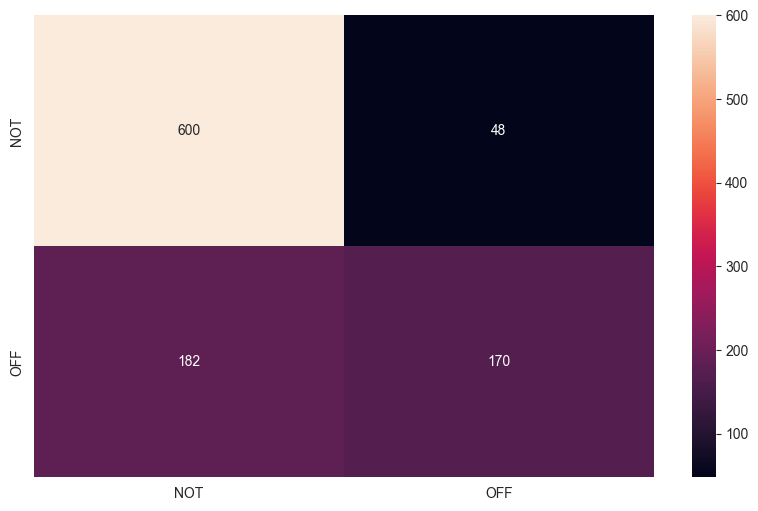

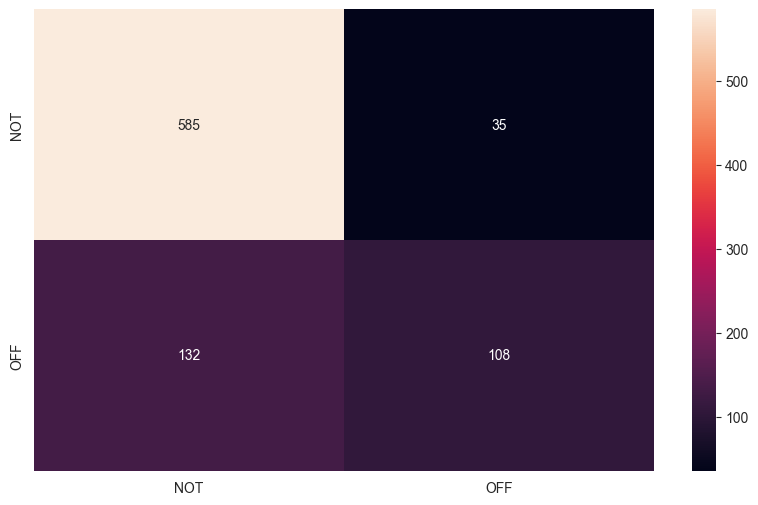

In [143]:
args = create_arg_parser()

# Read data
X_train, Y_train = read_corpus(args.train_file)
X_dev, Y_dev = read_corpus(args.dev_file)
X_test, Y_test = read_corpus(args.test_file)

# Setup vectorizer
vectorizer = setup_vectorizer(args.vectorizer)
embedding_dim = vectorizer.vector_size
voc = len(vectorizer)

# Create embedding matrix, used to store the word embeddings
embedding_matrix = np.zeros((voc, embedding_dim))

for vec_word, i in vectorizer.key_to_index.items():
    embedding_vector = vectorizer[vec_word]
    
    # If there is a vector for the word, store it in the embedding matrix
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Tokenize the words
tokenizer = Tokenizer(num_words=voc)
tokenizer.word_index = {word: index for word, index in vectorizer.key_to_index.items()}

# Tokenize and pad sequences for train, dev and test set
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_dev_seq = tokenizer.texts_to_sequences(X_dev)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, padding='post')
X_dev_padded = pad_sequences(X_dev_seq, padding='post', maxlen=X_train_padded.shape[1])
X_test_padded = pad_sequences(X_test_seq, padding='post', maxlen=X_train_padded.shape[1])

# One hot encode labels
encoder = LabelBinarizer() # label to a binary format

Y_train_onehot = encoder.fit_transform(Y_train)
Y_dev_onehot = encoder.transform(Y_dev)
Y_test_onehot = encoder.transform(Y_test)

input_length = X_train_padded.shape[1]

if os.path.isfile(args.model_name + ".keras"):
    model = tf.keras.models.load_model(args.model_name + ".keras")
else:
    model = create_model(embedding_matrix, input_length)

    model.fit(X_train_padded, Y_train_onehot, validation_data=(X_dev_padded, Y_dev_onehot), epochs=10, batch_size=128)
    model.save(args.model_name + ".keras")
    
print("Model configuration:")

print("Vectorizer: " + args.vectorizer)
print("Emoji to text representation: " + str(args.demojize))
print("Emoji to text representation clean: " + str(args.demojize_clean))
print("Word segmentation on hashtags: " + str(args.wordsegment))

# Evaluate model on test set
dev_predictions = model.predict(X_dev_padded)
dev_binary_predictions = [1 if pred[0] > 0.5 else 0 for pred in dev_predictions]

print("Accuracy score for dev set: {}".format(accuracy_score(Y_dev_onehot, dev_binary_predictions)))
print("f1 score for dev set macro: {}".format(f1_score(Y_dev_onehot, dev_binary_predictions, average='macro')))
print("f1 score for dev set micro: {}".format(f1_score(Y_dev_onehot, dev_binary_predictions, average='micro')))

# Printing confusion matrix
cf_matrix = confusion_matrix(Y_dev_onehot, dev_binary_predictions)
index = ["NOT", "OFF"]
columns  = ["NOT", "OFF"]
cm_df = pd.DataFrame(cf_matrix, columns, index)

fig = plt.figure(figsize=(10,6))
sns.heatmap(cm_df, annot=True, fmt='g')
fig.savefig(args.model_name + 'dev_matrix')

# Evaluate model on test set
test_predictions = model.predict(X_test_padded)
test_binary_predictions = [1 if pred[0] > 0.5 else 0 for pred in test_predictions]

print("Accuracy score for test set: {}".format(accuracy_score(Y_test_onehot, test_binary_predictions)))
print("f1 score for test set macro: {}".format(f1_score(Y_test_onehot, test_binary_predictions, average='macro')))
print("f1 score for test set micro: {}".format(f1_score(Y_test_onehot, test_binary_predictions, average='micro')))

# Printing confusion matrix
cf_matrix = confusion_matrix(Y_test_onehot, test_binary_predictions)
index = ["NOT", "OFF"]
columns  = ["NOT", "OFF"]
cm_df = pd.DataFrame(cf_matrix, columns, index)

fig = plt.figure(figsize=(10,6))
sns.heatmap(cm_df, annot=True, fmt='g')
fig.savefig(args.model_name + 'test_matrix')
